Episode 1/300, Reward: 26.0, Epsilon: 0.998
Episode 2/300, Reward: 14.0, Epsilon: 0.996
Episode 3/300, Reward: 12.0, Epsilon: 0.994
Episode 4/300, Reward: 13.0, Epsilon: 0.992


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 5/300, Reward: 12.0, Epsilon: 0.990
Episode 6/300, Reward: 30.0, Epsilon: 0.988
Episode 7/300, Reward: 30.0, Epsilon: 0.986
Episode 8/300, Reward: 10.0, Epsilon: 0.984
Episode 9/300, Reward: 20.0, Epsilon: 0.982
Episode 10/300, Reward: 20.0, Epsilon: 0.980
Episode 11/300, Reward: 33.0, Epsilon: 0.978
Episode 12/300, Reward: 13.0, Epsilon: 0.976
Episode 13/300, Reward: 15.0, Epsilon: 0.974
Episode 14/300, Reward: 25.0, Epsilon: 0.972
Episode 15/300, Reward: 11.0, Epsilon: 0.970
Episode 16/300, Reward: 33.0, Epsilon: 0.969
Episode 17/300, Reward: 17.0, Epsilon: 0.967
Episode 18/300, Reward: 14.0, Epsilon: 0.965
Episode 19/300, Reward: 16.0, Epsilon: 0.963
Episode 20/300, Reward: 11.0, Epsilon: 0.961
Episode 21/300, Reward: 23.0, Epsilon: 0.959
Episode 22/300, Reward: 26.0, Epsilon: 0.957
Episode 23/300, Reward: 73.0, Epsilon: 0.955
Episode 24/300, Reward: 25.0, Epsilon: 0.953
Episode 25/300, Reward: 44.0, Epsilon: 0.951
Episode 26/300, Reward: 22.0, Epsilon: 0.949
Episode 27/300,

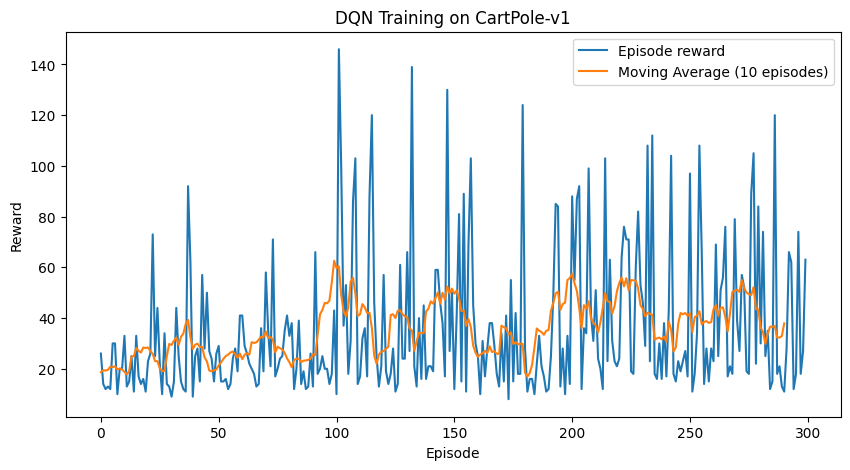

Training complete!


In [2]:
# -----------------------------------------------------------
# Advanced Deep Q-Network (DQN) with Gymnasium + Visualization
# -----------------------------------------------------------

"""
Theory Recap:
-------------
DQN combines Q-Learning with deep neural networks to handle
large/continuous state spaces. Key innovations are:

1. Experience Replay:
   - Store (state, action, reward, next_state, done) in a buffer.
   - Sample random batches to reduce correlation between updates.

2. Target Network:
   - Maintain two networks: Q (online) and Q_target (frozen copy).
   - Update target network slowly to stabilize training.

3. Exploration vs. Exploitation:
   - Use ε-greedy policy.
   - Start with high ε (explore more), decay over time to ε_min
     (exploit learned policy).

4. Loss Function:
   - Mean Squared Error (MSE) between predicted Q(s,a) and target:
       target = r + γ * max_a' Q_target(s', a')
"""

import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Neural Network for Q-function
# -----------------------------------------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # returns Q-values for all actions


# -----------------------------------------------------------
# Replay Buffer
# -----------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)


# -----------------------------------------------------------
# DQN Agent
# -----------------------------------------------------------
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3,
                 batch_size=64, buffer_capacity=10000, target_update=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Online Q-network & Target Q-network
        self.q_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        # Optimizer & Replay Buffer
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_capacity)

        self.steps = 0

    def select_action(self, state, epsilon):
        # ε-greedy policy
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_net(state)
            return q_values.argmax().item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Q(s,a)
        q_values = self.q_net(states).gather(1, actions)

        # Target Q-values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + self.gamma * next_q_values * (1 - dones)

        # Loss = MSE
        loss = nn.MSELoss()(q_values, target_q)

        # Gradient descent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


# -----------------------------------------------------------
# Training Loop
# -----------------------------------------------------------
def train_dqn(env_name="CartPole-v1", episodes=300):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)

    # Exploration schedule
    epsilon_start, epsilon_end, epsilon_decay = 1.0, 0.01, 500
    epsilon = epsilon_start
    rewards_history = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        for t in range(500):
            action = agent.select_action(state, epsilon)

            # Gymnasium API: step returns 5 values
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.update()

            state = next_state
            total_reward += reward

            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * np.exp(-1.0 / epsilon_decay))

        rewards_history.append(total_reward)
        print(f"Episode {ep+1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    env.close()
    return rewards_history


# -----------------------------------------------------------
# Run Training + Plot Rewards
# -----------------------------------------------------------
if __name__ == "__main__":
    rewards = train_dqn("CartPole-v1", episodes=300)

    # Plot rewards per episode
    plt.figure(figsize=(10,5))
    plt.plot(rewards, label="Episode reward")
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'),
             label="Moving Average (10 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DQN Training on CartPole-v1")
    plt.legend()
    plt.show()

    print("Training complete!")
